In [1]:
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain
from datetime import timedelta, date, datetime, timezone
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

In [2]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%('docker','docker',dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [3]:
league_id = 84057

### Pull injured players

In [4]:
url = 'https://fantasy.espn.com/apis/v3/games/FBA/seasons/2020/segments/0/leagues/' + str(league_id)
params={"view": "kona_player_info"}
cookies = {"swid": AUTH['swid'],
           "espn_s2": AUTH['espn_s2']}
r = requests.get(url, params=params, cookies=cookies)
data = r.json()
data.keys()

dict_keys(['players'])

In [5]:
injured_out = []
injured_dtd = []
for player in data['players']:
    for stat_item in player['player']['stats']:
        if stat_item['id'] == '002020':
            if 'injuryStatus' in player['player'].keys():
                if player['player']['injuryStatus'] == 'OUT':
                    injured_out.append(player['player']['fullName'])
                if player['player']['injuryStatus'] == 'DAY_TO_DAY':
                    injured_dtd.append(player['player']['fullName'])

### Pull matchup data

In [6]:
url = 'https://fantasy.espn.com/apis/v3/games/FBA/seasons/2020/segments/0/leagues/' + str(league_id)
params={"view": "mBoxscore"}
cookies = {"swid": AUTH['swid'],
           "espn_s2": AUTH['espn_s2']}
r = requests.get(url, params=params, cookies=cookies)
data = r.json()

In [7]:
today = datetime.strftime(datetime.now(), format='%Y-%m-%d')
print(today)

2020-01-27


In [8]:
# get matchup end date and match up period using current day
sql = """
    SELECT *
    FROM matchup_end_dates 
    WHERE end_date >= '{}'
    ORDER BY end_date ASC
""".format(today)
matchup = pd.read_sql(sql, engine)
matchup_end_date = matchup.end_date.values[0]
matchupPeriod = matchup.matchup_period.values[0]
print(matchup_end_date, matchupPeriod)

2020-02-02 15


In [9]:
# if matchup period hasn't started yet, then this doesn't work
# doesn't appear to be an obvious workaround 
teamId = 10
team_totals = {}
opponent_totals = {}
for matchup in data['schedule']:
    if ((matchup['away']['teamId'] == teamId) or (matchup['home']['teamId'] == teamId)) & (matchup['matchupPeriodId'] == matchupPeriod):
        
        if matchup['away']['teamId'] == teamId:
            team_role = 'away'
            opponent_role = 'home'
        else:
            team_role = 'home'
            opponent_role = 'away'
        
        team_players = []
        opponent_players = []
        for entry in matchup[team_role]['rosterForCurrentScoringPeriod']['entries']:
            # 12 is bench players if I also want to remove them
            # but have to make sure their lineup is set correctly
            if (entry['lineupSlotId'] != 13) & (entry['playerPoolEntry']['player']['fullName'] not in injured_out):
                team_players.append({'fullName':entry['playerPoolEntry']['player']['fullName'],
                                    'proTeamId':entry['playerPoolEntry']['player']['proTeamId']})
        for entry in matchup[opponent_role]['rosterForCurrentScoringPeriod']['entries']:
            if (entry['lineupSlotId'] != 13) & (entry['playerPoolEntry']['player']['fullName'] not in injured_out):
                opponent_players.append({'fullName':entry['playerPoolEntry']['player']['fullName'],
                                    'proTeamId':entry['playerPoolEntry']['player']['proTeamId']})

        team_totals['points'] = matchup[team_role]['cumulativeScore']['scoreByStat']['0']['score']
        team_totals['blocks'] = matchup[team_role]['cumulativeScore']['scoreByStat']['1']['score']
        team_totals['steals'] = matchup[team_role]['cumulativeScore']['scoreByStat']['2']['score']
        team_totals['assists'] = matchup[team_role]['cumulativeScore']['scoreByStat']['3']['score']
        team_totals['rebounds'] = matchup[team_role]['cumulativeScore']['scoreByStat']['6']['score']
        team_totals['threes'] = matchup[team_role]['cumulativeScore']['scoreByStat']['17']['score']
        team_totals['fga'] = matchup[team_role]['cumulativeScore']['scoreByStat']['14']['score']
        team_totals['fgm'] = matchup[team_role]['cumulativeScore']['scoreByStat']['13']['score']
        team_totals['fta'] = matchup[team_role]['cumulativeScore']['scoreByStat']['16']['score']
        team_totals['ftm'] = matchup[team_role]['cumulativeScore']['scoreByStat']['15']['score']

        opponent_totals['points'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['0']['score']
        opponent_totals['blocks'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['1']['score']
        opponent_totals['steals'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['2']['score']
        opponent_totals['assists'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['3']['score']
        opponent_totals['rebounds'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['6']['score']
        opponent_totals['threes'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['17']['score']
        opponent_totals['fga'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['14']['score']
        opponent_totals['fgm'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['13']['score']
        opponent_totals['fta'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['16']['score']
        opponent_totals['ftm'] = matchup[opponent_role]['cumulativeScore']['scoreByStat']['15']['score']
        
        break

team_players_df = pd.DataFrame(team_players)
opponent_players_df = pd.DataFrame(opponent_players)

In [10]:
team_players_df

,fullName,proTeamId
0,Buddy Hield,23
1,Giannis Antetokounmpo,15
2,Nikola Jokic,7
3,PJ Washington,30
4,Derrick Rose,8
5,Nerlens Noel,25
6,Julius Randle,18
7,Tomas Satoransky,4
8,Markelle Fultz,19
9,Taurean Prince,17


In [11]:
opponent_players_df

,fullName,proTeamId
0,D'Angelo Russell,9
1,Rudy Gobert,26
2,Shai Gilgeous-Alexander,25
3,CJ McCollum,22
4,Derrick Favors,3
5,Steven Adams,25
6,Gordon Hayward,2
7,Dwight Howard,13
8,Kelly Oubre Jr.,21
9,Eric Gordon,10


### Test get n_games per day for my team

In [12]:
start_date = datetime.strftime(datetime.now(), format='%Y-%m-%d')
teamIdList = '(' + ', '.join(opponent_players_df.proTeamId.astype(str)) + ')'
sql = """
    SELECT *
    FROM espn_team_ids eid
    JOIN nba_schedule sch ON eid.scraped_name = sch.home_team OR eid.scraped_name = sch.away_team 
    WHERE espn_team_id IN {} AND sch.season_end_year = 2020 AND start_date >= '{}' AND start_date <= '{}'
""".format(teamIdList, start_date, matchup_end_date)
games = pd.read_sql(sql, engine)

teamCounts = pd.DataFrame(team_players_df.proTeamId.value_counts())
teamCounts.rename(columns={'proTeamId':'team_count'}, inplace=True)
teamCounts = teamCounts.loc[teamCounts.team_count > 1]
for i in range(len(teamCounts)):
    teamId = teamCounts.index.values[i]
    team_count = teamCounts.team_count.values[i]
    games = games.append([games.loc[games.espn_team_id == teamId]] * (team_count - 1), ignore_index=True)

In [13]:
games.start_date.value_counts(), games.start_date.value_counts().sum()

(2020-01-28    6
 2020-02-01    6
 2020-01-31    6
 2020-01-29    5
 2020-01-30    3
 2020-02-02    3
 2020-01-27    3
 Name: start_date, dtype: int64, 32)

In [14]:
start_date = datetime.strftime(datetime.now(), format='%Y-%m-%d')
teamIdList = '(' + ', '.join(team_players_df.proTeamId.astype(str)) + ')'
sql = """
    SELECT *
    FROM espn_team_ids eid
    JOIN nba_schedule sch ON eid.scraped_name = sch.home_team OR eid.scraped_name = sch.away_team 
    WHERE espn_team_id IN {} AND sch.season_end_year = 2020 AND start_date >= '{}' AND start_date <= '{}'
""".format(teamIdList, start_date, matchup_end_date)
games = pd.read_sql(sql, engine)

teamCounts = pd.DataFrame(team_players_df.proTeamId.value_counts())
teamCounts.rename(columns={'proTeamId':'team_count'}, inplace=True)
teamCounts = teamCounts.loc[teamCounts.team_count > 1]
for i in range(len(teamCounts)):
    teamId = teamCounts.index.values[i]
    team_count = teamCounts.team_count.values[i]
    games = games.append([games.loc[games.espn_team_id == teamId]] * (team_count - 1), ignore_index=True)

In [15]:
games.start_date.value_counts(), games.start_date.value_counts().sum()

(2020-01-29    8
 2020-02-01    7
 2020-01-31    7
 2020-01-27    7
 2020-01-28    5
 2020-02-02    5
 2020-01-30    4
 Name: start_date, dtype: int64, 43)

### Generating simulated data

In [16]:
# add season end year to boxscores and limit by that?

In [22]:
n_samples = 1000
team_samples = []
opponent_samples = []
start_date = today
print(start_date)

# iterate over players
for i in range(len(team_players_df)):

    player = team_players_df.iloc[i]['fullName']
    teamId = team_players_df.iloc[i]['proTeamId']
    print("Processing " + player)
    
    # get player boxscores
    # join on player_name_comparison in case name doesn't match, this query should work ok
    sql = """
        SELECT * FROM boxscores b
        LEFT JOIN player_name_comparison c ON b.name = c.boxscore_name
        WHERE (c.espn_name = %(player)s) OR (b.name = %(player)s)
    """
    player_boxscores = pd.read_sql(sql, engine, params = {'player': player})
    
    # get n_games for this matchup
    sql = """
        SELECT COUNT(*)
        FROM espn_team_ids eid
        JOIN nba_schedule sch ON eid.scraped_name = sch.home_team OR eid.scraped_name = sch.away_team 
        WHERE espn_team_id = {} AND sch.season_end_year = 2020 AND start_date >= '{}' AND start_date <= '{}'
    """.format(teamId, start_date, matchup_end_date)
    n_games = pd.read_sql(sql, engine).values[0][0]
    print(n_games)

    for sample in range(n_samples):
        player_samples = player_boxscores.sample(replace=False, n=n_games)
        player_samples['sample_i'] = sample
        team_samples.append(player_samples.to_dict('records'))
        
for i in range(len(opponent_players_df)):
        
    player = opponent_players_df.iloc[i]['fullName']
    teamId = opponent_players_df.iloc[i]['proTeamId']
    print("Processing " + player)
    
    # get player boxscores
    sql = """
        SELECT * FROM boxscores b
        LEFT JOIN player_name_comparison c ON b.name = c.boxscore_name
        WHERE (c.espn_name = %(player)s) OR (b.name = %(player)s)
    """
    player_boxscores = pd.read_sql(sql, engine, params = {'player': player})
    
    # get n_games for this matchup
    sql = """
        SELECT COUNT(*)
        FROM espn_team_ids eid
        JOIN nba_schedule sch ON eid.scraped_name = sch.home_team OR eid.scraped_name = sch.away_team 
        WHERE espn_team_id = {} AND sch.season_end_year = 2020 AND start_date >= '{}' AND start_date <= '{}'
    """.format(teamId, start_date, matchup_end_date)
    n_games = pd.read_sql(sql, engine).values[0][0]
    print(n_games)

    for sample in range(n_samples):
        player_samples = player_boxscores.sample(replace=False, n=n_games)
        player_samples['sample_i'] = sample
        opponent_samples.append(player_samples.to_dict('records'))

team_samples_df = pd.DataFrame(list(chain.from_iterable(team_samples)))
opponent_samples_df = pd.DataFrame(list(chain.from_iterable(opponent_samples)))

team_totals_samples = []
opponent_total_samples = []
# iterate over samples
for sample in range(n_samples):
    
    sample_totals = {}
    team_samples_df.loc[team_samples_df['sample_i']==sample]
    sample_totals['sample_i'] = sample
    for stat in ['assists','blocks','fga','fgm','fta','ftm','points','rebounds','steals','threes']:
        sample_totals[stat] = team_totals[stat] + team_samples_df.loc[team_samples_df['sample_i']==sample][stat].sum()
    team_totals_samples.append(sample_totals)
    
    sample_totals = {}
    opponent_samples_df.loc[opponent_samples_df['sample_i']==sample]
    sample_totals['sample_i'] = sample
    for stat in ['assists','blocks','fga','fgm','fta','ftm','points','rebounds','steals','threes']:
        sample_totals[stat] = opponent_totals[stat] + opponent_samples_df.loc[opponent_samples_df['sample_i']==sample][stat].sum()
    opponent_total_samples.append(sample_totals)
    
team_totals_samples_df = pd.DataFrame(team_totals_samples)
team_totals_samples_df['ft_pct'] = team_totals_samples_df.ftm / team_totals_samples_df.fta
team_totals_samples_df['fg_pct'] = team_totals_samples_df.fgm / team_totals_samples_df.fga
opponent_total_samples_df = pd.DataFrame(opponent_total_samples)
opponent_total_samples_df['ft_pct'] = opponent_total_samples_df.ftm / opponent_total_samples_df.fta
opponent_total_samples_df['fg_pct'] = opponent_total_samples_df.fgm / opponent_total_samples_df.fga

2020-01-27
Processing Buddy Hield
4
Processing Giannis Antetokounmpo
3
Processing Nikola Jokic
4
Processing PJ Washington
3
Processing Derrick Rose
4
Processing Nerlens Noel
3
Processing Julius Randle
3
Processing Tomas Satoransky
4
Processing Markelle Fultz
2
Processing Taurean Prince
3
Processing Matisse Thybulle
3
Processing Jakob Poeltl
3
Processing Kris Dunn
4
Processing D'Angelo Russell
3
Processing Rudy Gobert
4
Processing Shai Gilgeous-Alexander
3
Processing CJ McCollum
3
Processing Derrick Favors
3
Processing Steven Adams
3
Processing Gordon Hayward
3
Processing Dwight Howard
3
Processing Kelly Oubre Jr.
3
Processing Eric Gordon
4
Processing Marcus Morris Sr.
3


In [23]:
# do comparison for each cat
merged = team_totals_samples_df.merge(opponent_total_samples_df, on='sample_i')
results = {}
for stat in ['assists','blocks','fg_pct','ft_pct','points','rebounds','steals','threes']:
    results[stat] = (merged[stat+'_x'] > merged[stat+'_y']).sum()

In [24]:
results

{'assists': 1000,
 'blocks': 343,
 'fg_pct': 414,
 'ft_pct': 767,
 'points': 907,
 'rebounds': 757,
 'steals': 956,
 'threes': 580}

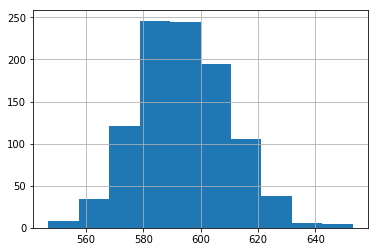

In [21]:
merged['points_x'].hist(bins=10);  

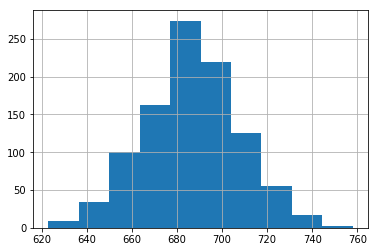

In [22]:
merged['points_y'].hist(bins=10);

In [ ]:
# I could write these results for every team to a database which I then use to populate an R-shiny 